In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [2]:
data_batches = []
labels_batches = []

for i in range(1, 6):
    batch = unpickle(f"data/cifar-10-batches-py/data_batch_{i}")
    data_batches.append(batch[b'data'])
    labels_batches.append(batch[b'labels'])

In [3]:
import numpy as np

images_train = np.concatenate(data_batches) 
y_train = np.concatenate(labels_batches)

test_batch = unpickle("data/cifar-10-batches-py/test_batch")
images_test = test_batch[b'data']
y_test = test_batch[b'labels']

In [4]:
import cv2

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    
    cv2.normalize(hist, hist)
    
    return hist.flatten()

In [5]:
import pickle

def load_cifar10_batch(files_list):
    images = None
    labels = None
    for file in files_list:
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        if images is None:
            images = dict[b'data']
        else:
            images = np.concatenate((images, dict[b'data']))
        if labels is None:
            labels = dict[b'labels']
        else:    
            labels = np.concatenate((labels, dict[b'labels']))
            
    images = images.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    return images, labels

In [6]:
files_list = ["data/cifar-10-batches-py/data_batch_1", "data/cifar-10-batches-py/data_batch_2", "data/cifar-10-batches-py/data_batch_3", "data/cifar-10-batches-py/data_batch_4", "data/cifar-10-batches-py/data_batch_5"]

images_train, labels_train = load_cifar10_batch(files_list)

In [7]:
X_train = []
for image in images_train:
    histogram = extract_color_histogram(image)
    X_train.append(histogram)

X_train = np.array(X_train)
y_train = np.array(labels_train)

In [8]:
images_test, labels_test = load_cifar10_batch(["data/cifar-10-batches-py/test_batch"])

In [9]:
X_test = []
for image in images_test:
    histogram = extract_color_histogram(image)
    X_test.append(histogram)

X_test = np.array(X_test)
y_test = np.array(labels_test)

# Random Forest

## Grid search

In [10]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# clf = RandomForestClassifier()

# param_grid = {
#     'n_estimators': [50, 100],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [5, 10],
#     'min_samples_leaf': [1, 2, 4],
# }

# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters: ", grid_search.best_params_)

# y_pred = grid_search.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)


Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Accuracy:  0.4172


### Best parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [13]:
from sklearn.ensemble import RandomForestClassifier

randomForestModel = RandomForestClassifier(n_estimators=100, max_depth=None,min_samples_leaf=1, min_samples_split=5, random_state=42)

randomForestModel.fit(X_train, y_train)

y_pred = randomForestModel.predict(X_test)

accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4169


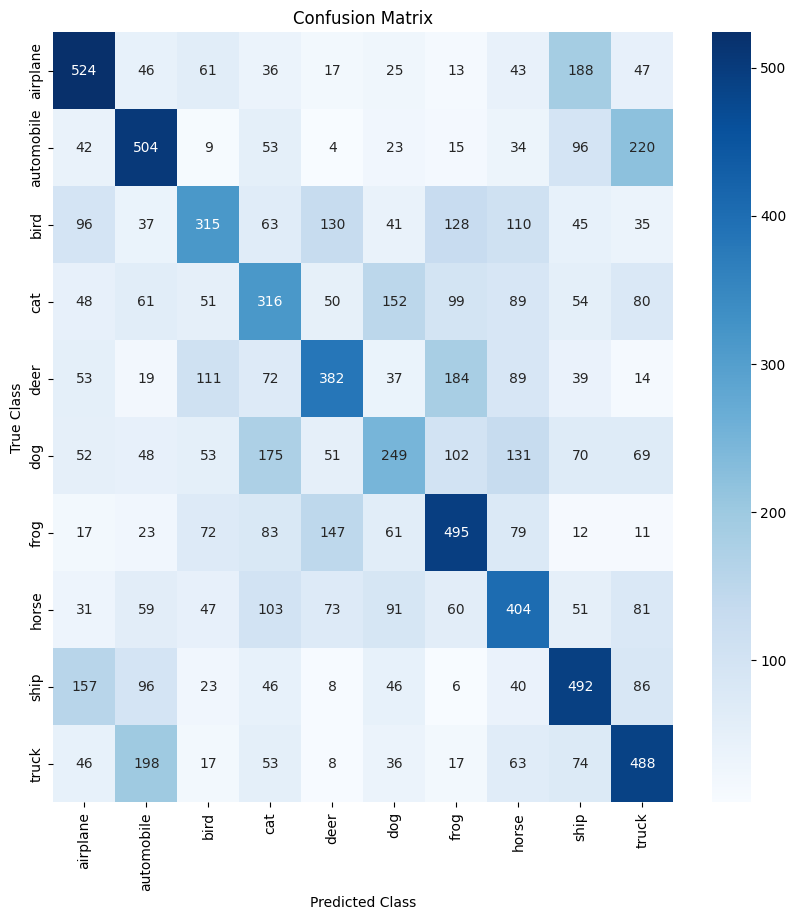

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

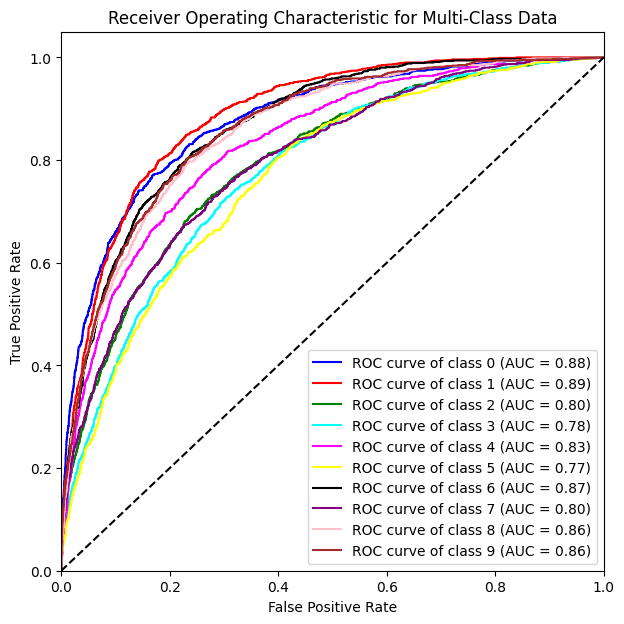

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = randomForestModel.predict_proba(X_test)  # Remplacez ici par votre classificateur et vos données de test

colors = cycle(['blue', 'red', 'green', 'cyan', 'magenta', 'yellow', 'black', 'purple', 'pink', 'brown'])
class_names = range(10)  # Remplacez ici par vos vrais noms de classe

plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    # Calculer la courbe ROC pour la i-ème classe
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])

    # Calculer l'aire sous la courbe ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Tracer la courbe ROC
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

# Tracer la ligne de hasard
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class Data')
plt.legend(loc="lower right")
plt.show()


# Régression logistique

## Grid search

In [22]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# model = LogisticRegression(max_iter=20000)

# param_grid = {
#     'C': [0.01, 0.1, 1, 10],
#     'penalty': ['l1', 'l2'],
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print("Best parameters: ", grid_search.best_params_)

# y_pred = grid_search.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)


/home/kephas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/kephas/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
   

Best parameters:  {'C': 1, 'penalty': 'l2'}
Accuracy:  0.3463


### Best parameters:  {'C': 1, 'penalty': 'l2'}

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=20000, C=1, penalty='l2', random_state=42)

model.fit(X_train, y_train)

print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

Train accuracy: 0.36618
Test accuracy: 0.3463


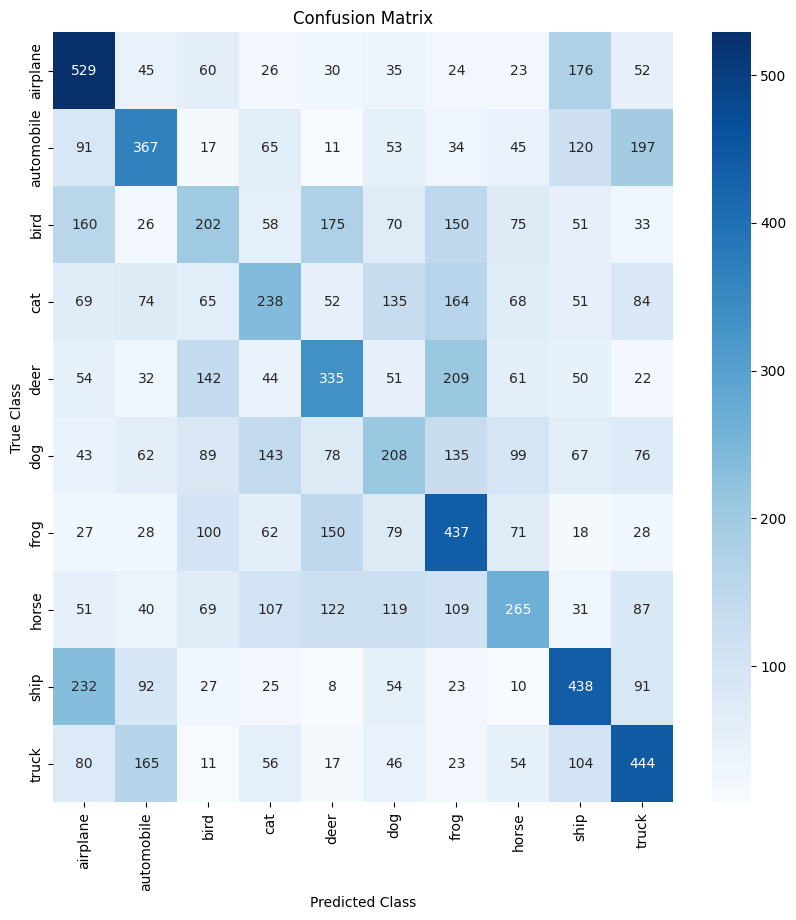

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

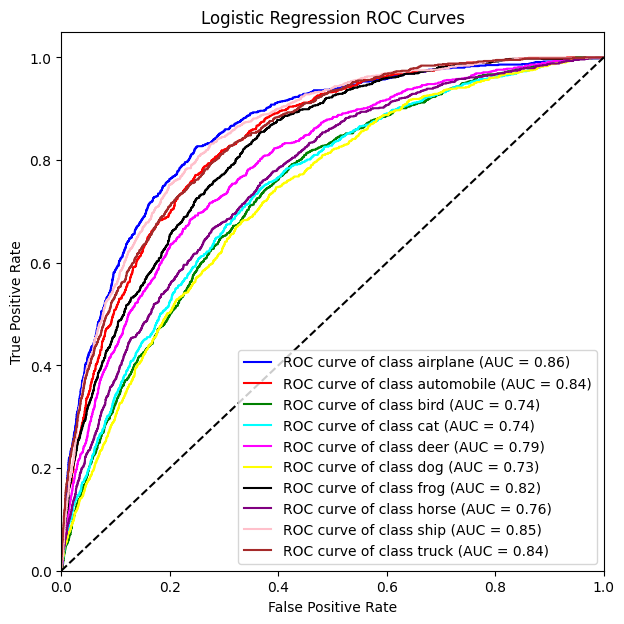

In [25]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = model.predict_proba(X_test)


plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curves')
plt.legend(loc="lower right")
plt.show()

# SGD Classifier

In [29]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# # Définir le modèle
# model = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

# # Définir la grille de paramètres pour la recherche sur grille
# param_grid = {
#     'loss': ['hinge', 'log'],
#     'alpha': [0.001, 0.01, 0.1, 1],
#     'penalty': ['l2', 'l1'],
# }

# # Initialiser la recherche sur grille
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1)

# # Ajuster le modèle aux données
# grid_search.fit(X_train, y_train)

# # Imprimer les meilleurs paramètres
# print("Best parameters: ", grid_search.best_params_)

# # Utiliser le meilleur modèle pour faire des prédictions
# y_pred = grid_search.predict(X_test)

# # Calculer la précision
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: ", accuracy)


/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/ke

Best parameters:  {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
Accuracy:  0.3154


### Best parameters:  {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}

In [30]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

model = SGDClassifier(loss='log', alpha=0.001, penalty='l2',
                      max_iter=1000, tol=1e-3, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

/home/kephas/.local/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy: 0.3154


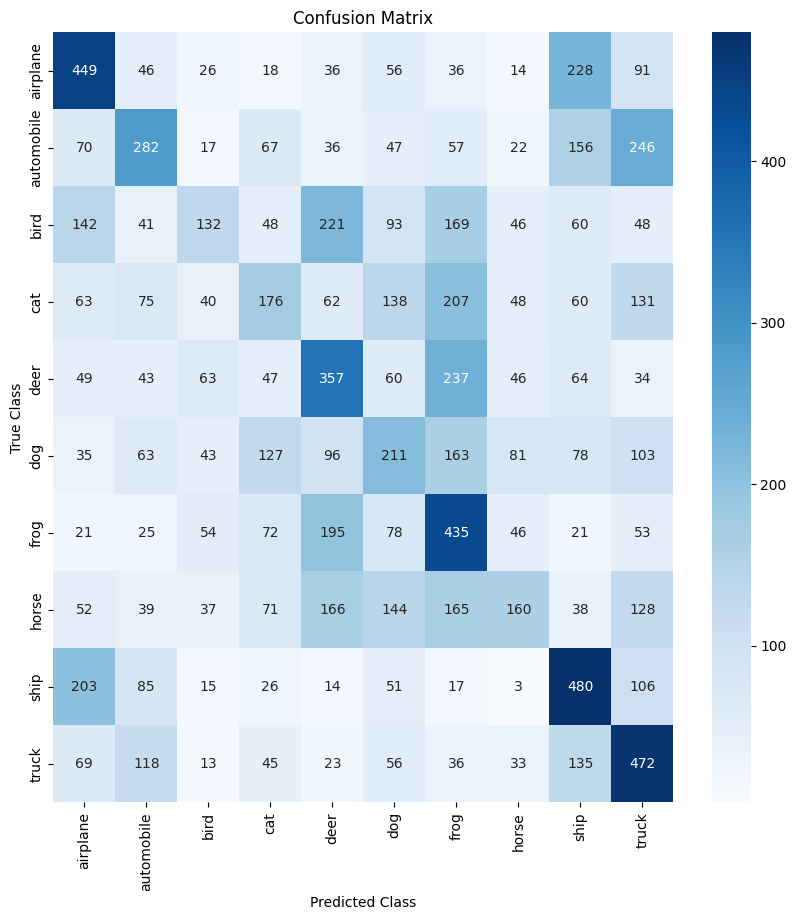

In [31]:
y_pred = model.predict(X_test)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Visualiser la matrice de confusion
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

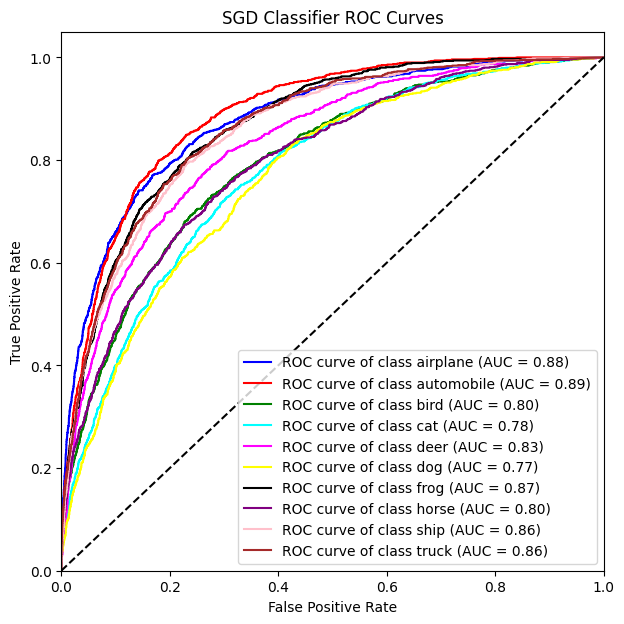

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_bin = randomForestModel.predict_proba(X_test)


plt.figure(figsize=(7, 7))

for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SGD Classifier ROC Curves')
plt.legend(loc="lower right")
plt.show()